#  Airbnb Socioeconomic London Analysis Wrangling Project Report

This report documents my data wrangling, merging, analysis, and insight generation process using multiple public datasets, focusing on the socioeconomic effects of Airbnb in London. It follows a structured pipeline as required by the project brief.


##  1. Dataset Sourcing and Auditing

###  Dataset 1: Airbnb Listings (`listings1.csv`)
- **Source**: Provided Airbnb dataset
- **Format**: CSV
- **Structure**: 79 columns, ~94,559 rows
- **Initial Audit**:
  - Missing values in fields such as `description`, `neighborhood_overview`, `license`
  - Columns like `scrape_id`, `calendar_updated` have no meaningful value
  - Price field is stored as string and needs conversion

###  Dataset 2: Housing in London (Monthly & Yearly)
- **Source**: London (Kaggle.com)
- **Links**:
  - [Monthl Housing Variables](https://data.london.gov.uk/dataset/housing-in-london)
  - [Yearly Housing Variables](https://data.london.gov.uk/dataset/housing-in-london)
- **Format**: CSV
- **Structure**: Each file has ~15-17 columns with borough-wise housing info
- **Initial Audit**:
  - Borough names need standardization
  - Missing values in fields like `average_price`, `life_satisfaction`

###  Dataset 3: Airbnb Reviews (`reviews1.csv`)
- **Source**: Provided Airbnb dataset
- **Format**: CSV
- **Structure**: Review-level data with timestamps and text
- **Initial Audit**:
  - Time data irregularities
  - Needs to be merged on `listing_id` to add review sentiment metrics

###  Dataset 4: Gross Value Added Data (`regional_gva_data`)
- **Source**: Web Scraped dataset
- **Format**: Data-Frame
- **Structure**: Review-level data with timestamps and text
- **Initial Audit**:
  - Time data irregularities
  - Needs to be merged on `listing_id` to add review sentiment metrics
(https://en.wikipedia.org/wiki/Economy_of_London)


##  2. Data Cleaning and Combination

The following steps were taken to prepare the final dataset:

1. **Loaded** all three datasets with `pandas.read_csv()`.
2. **Dropped irrelevant columns** with `df.drop()`, e.g. `scrape_id`, `calendar_updated`.
3. **Converted price fields** to numeric using string operations and `pd.to_numeric()`.
4. **Merged listings and reviews** on `id` and `listing_id`.
5. **Filtered boroughs** to only include Greater London.
6. **Merged housing data** with Airbnb listings using `borough` and `year`.
7. **Derived new fields** like:
   - `listings_per_1000_people`
   - `listings_per_1000_jobs`
   - `listings_per_1000_houses`
8. **Stored final combined dataset** in a CSV and uploaded to Google Drive.

🔗 **[Final Dataset CSV (Google Drive)](https://drive.google.com/drive/u/7/home)** — accessible with view permissions.


##  3. Key Research Questions and Conclusions Informed by Analytical and Web-Scraped Data

### Q1. How do Airbnb listing prices compare with average residential property prices across boroughs and time?
- **Approach**: Merged calendar-level Airbnb pricing data with borough-level average housing prices from the Kaggle dataset (monthly variables).
- **Finding**: In many boroughs, Airbnb prices per night exceed residential rental estimates when adjusted for occupancy, indicating possible pricing pressure on the housing market.

### Q2. Is there a relationship between the density of Airbnb listings and changes in population, housing supply, or number of jobs in London boroughs?
- **Approach**: Calculated Airbnb listing counts per 1000 population, houses, and jobs, and merged with yearly demographic indicators.
- **Finding**: A clear pattern emerges where boroughs with rising population and job counts also show increased Airbnb density, possibly stressing local infrastructure and housing availability.

### Q3. Do boroughs with high Airbnb review scores for location and value also show higher life satisfaction and safety (crime rate) metrics?
- **Approach**: Extracted borough-level average scores for `review_scores_location` and `review_scores_value`, and merged with crime and life satisfaction data.
- **Finding**: Boroughs like Richmond and Kensington exhibit both high review scores and high life satisfaction with lower crime rates, implying a possible alignment between digital reputation and real-life urban well-being.

### Q4. Do boroughs with higher economic productivity (GVA per head) also have more Airbnb listings and greater guest engagement, indicating a concentration of tourism activity in economically strong areas?
- **Approach**: GVA per borough (scraped from Wikipedia and ons.gov.uk) was merged with Airbnb listing counts and reviews per listing.
- **Finding**: Boroughs such as Westminster and Camden show both high GVA and high Airbnb activity, suggesting tourism aligns with economic hotspots.



## 4. Limitation of Combined Dataset and Web Scraping Solution

### Limitation

While our combined dataset enabled analysis across Airbnb listings, housing trends, and socioeconomic factors, it could not help answer the following key question:

**Do boroughs with higher economic productivity (e.g., GVA per head) also experience increased Airbnb engagement and tourism density?**

The limitation stems from the absence of borough-level Gross Value Added (GVA) metrics in the provided or sourced datasets. These data are typically available through statistical releases or economic reports, but not in a directly downloadable or structured format suitable for merging.

### Web Scraping Strategy

To address this limitation, we identified and attempted to scrape GVA data from multiple online sources, including:
- Wikipedia (e.g., *Economy of London* page)
- UK Office for National Statistics
- Local borough economic summary pages

However, several practical challenges were encountered during the scraping process:

- CAPTCHA protection blocked many scraping attempts
- JavaScript-rendered tables could not be accessed via basic HTTP requests
- Some websites returned incomplete HTML or redirected when automated access was detected

### Custom Scraping Workaround

To bypass these limitations, we developed a basic HTML scraper using Python’s `requests` and `BeautifulSoup` libraries. We targeted a publicly available Wikipedia page that contained a static HTML table with GVA values for each London borough.

The page was selected because:
- It did not require JavaScript rendering
- The table structure was well-defined and parsable
- Borough names matched those in our primary dataset, minimizing transformation needs

This allowed us to reliably extract the data for integration without triggering site protection mechanisms.

### Pseudocode for the Scraper

```python
1. Define the URL of the GVA source (e.g., Wikipedia page)
2. Send a GET request using `requests`
3. Parse the HTML content with `BeautifulSoup`
4. Locate the relevant table containing borough-wise GVA data
5. Loop through each row and extract:
   - Borough name
   - GVA value
6. Append extracted values into a structured format (e.g., a list or DataFrame)
7. Export the scraped data to CSV or merge it directly with the existing dataset


In [485]:
#importing all the library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import csv
import requests
from bs4 import BeautifulSoup
import matplotlib.ticker as ticker

### IMPORTING THE REQUIRED LIBRARY

In [ ]:
#loading all the required datasets
df_bnb = pd.read_csv("listings1.csv")
df_mHousing = pd.read_csv("housing_in_london_monthly_variables.csv")
df_yHousing = pd.read_csv("housing_in_london_yearly_variables.csv")
reviews = pd.read_csv("reviews1.csv")

In [454]:
#Understand lisiting table
df_bnb.info()
df_bnb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94559 entries, 0 to 94558
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            94559 non-null  int64  
 1   listing_url                                   94559 non-null  object 
 2   scrape_id                                     94559 non-null  int64  
 3   last_scraped                                  94559 non-null  object 
 4   source                                        94559 non-null  object 
 5   name                                          94559 non-null  object 
 6   description                                   91866 non-null  object 
 7   neighborhood_overview                         42281 non-null  object 
 8   picture_url                                   94555 non-null  object 
 9   host_id                                       94559 non-null 

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,91031,https://www.airbnb.com/rooms/91031,20250304052011,2025-03-10,city scrape,Apartment by Battersea Power Station,"Cozy 1 bedroom flat, perfect for a couple or s...","Flat is located on South side of Thames, East ...",https://a0.muscache.com/pictures/miso/Hosting-...,491004,...,4.75,4.64,4.28,NaN,f,1,1,0,0,0.15
1,91287,https://www.airbnb.com/rooms/91287,20250304052011,2025-03-12,previous scrape,"The Barnsbury, London Apartment w/WIFI",NaN,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,493497,...,4.66,4.51,4.29,NaN,f,4,4,0,0,0.39
2,92352,https://www.airbnb.com/rooms/92352,20250304052011,2025-03-12,previous scrape,Flat in Islington,My place is close to Highbury & Islington Tube...,"My neighbourhood is exciting, lively, cosmopol...",https://a0.muscache.com/pictures/9f12e168-cb11...,497172,...,4.97,4.95,4.77,NaN,f,1,1,0,0,0.73
3,92399,https://www.airbnb.com/rooms/92399,20250304052011,2025-03-15,city scrape,modern self contained flat islington,"FULLY SELF CONTAINED. A newly renovated, self...",Newington Green is a wonderful little pocket o...,https://a0.muscache.com/pictures/hosting/Hosti...,497366,...,4.96,4.82,4.77,NaN,f,2,2,0,0,1.90
4,93015,https://www.airbnb.com/rooms/93015,20250304052011,2025-03-06,city scrape,2 bed West Kensington apartment,Gorgeous 2 bed ground floor apartment with per...,A bit of history about the W14 area: <br />Com...,https://a0.muscache.com/pictures/865937ec-ee56...,499704,...,4.90,4.87,4.74,NaN,f,1,1,0,0,0.25


### Wrangling the loaded data according to the Analysis



### Wrangling the Loaded Data According to the Analysis

To perform meaningful analysis, we conducted a thorough wrangling process across multiple datasets. Each dataset required specific cleaning, transformation, or merging operations to align with the overall goals of this project. Below is a summary of the wrangling steps applied to each key dataset.

---

#### 1. **Airbnb Listings Data (`listings.csv.gz`)**
- **Purpose**: Provided detailed property-level information including location, price, review scores, and room types.
- **Wrangling Steps**:
  - Filtered only London-based entries using the `neighbourhood_group_cleansed`.
  - Parsed relevant fields such as `price`, `review_scores_rating`, `review_scores_location`, and `review_scores_value`.
  - Extracted listing-level borough names and standardized them for merging (e.g., uppercased and stripped extra spaces).
  - Aggregated data by borough to compute average Airbnb price, review scores, and number of listings.


---
#### 2. **Airbnb Reviews Data (`reviews.csv.gz`)**
- **Purpose**: Provided time-stamped user reviews, which we used as a **proxy for booking activity** across time.
- **Wrangling Steps**:
  - Selected only `listing_id` and `date` columns, treating the review date as a **proxy for booking date**.
  - Merged this review dataset with `listings.csv.gz` on `listing_id` to associate each review with a specific borough.
  - Aggregated the merged data to compute:
    - Total number of reviews per borough
    - Yearly review activity to estimate Airbnb engagement trends
  - This helped us evaluate **borough-level guest activity** and align it with other metrics like life satisfaction and crime.

---

#### 3. **Housing in London Yearly Variables (`housing_in_london_yearly_variables.csv`)**
- **Purpose**: Provided borough-level socioeconomic indicators (population size, life satisfaction, crime, housing supply, etc.).
- **Wrangling Steps**:
  - Filtered to include only entries flagged as London boroughs.
  - Removed irrelevant fields like area codes and non-borough entries.
  - Cleaned and renamed columns for clarity (e.g., `population_size`, `number_of_jobs`, `life_satisfaction`).
  - Converted relevant fields to numeric and handled missing values (e.g., interpolation or exclusion).

---

#### 4. **Housing in London Monthly Variables (`housing_in_london_monthly_variables.csv`)**
- **Purpose**: Provided borough-level housing price trends and crime on a monthly basis.
- **Wrangling Steps**:
  - Grouped data to compute annual average housing price per borough for consistency with other datasets.
  - Renamed columns and standardized borough names for merging.
  - Computed derived metrics such as `average_price_index` for housing trends.


### Outcome:
This multi-step wrangling process enabled us to align different temporal, spatial, and structural data sources into a unified dataset. The clean dataset allowed us to generate accurate borough-level comparisons across Airbnb trends, housing affordability, crime rates, population size, review behavior, and economic productivity.


In [455]:
#Keeping relevant columns only
bnb_filtered = df_bnb[[
    'id', 'price', 'neighbourhood_cleansed',
    'review_scores_location', 'review_scores_rating', 
    'calculated_host_listings_count'
]]

bnb_filtered.info()
bnb_filtered.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94559 entries, 0 to 94558
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              94559 non-null  int64  
 1   price                           60341 non-null  object 
 2   neighbourhood_cleansed          94559 non-null  object 
 3   review_scores_location          70272 non-null  float64
 4   review_scores_rating            70317 non-null  float64
 5   calculated_host_listings_count  94559 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 4.3+ MB


,id,price,neighbourhood_cleansed,review_scores_location,review_scores_rating,calculated_host_listings_count
0,91031,$94.00,Wandsworth,4.64,4.23,1
1,91287,NaN,Islington,4.51,4.51,4
2,92352,NaN,Islington,4.95,4.86,1
3,92399,$86.00,Islington,4.82,4.84,2
4,93015,$175.00,Hammersmith and Fulham,4.87,4.85,1


In [456]:
#Removing price column by removing '$' symbol and converting the datatype to float
def priceCleaning(val):
    return float(val.replace('$','').replace(',',''))

bnb_filtered['price'] = bnb_filtered['price'].astype(str).apply(priceCleaning)
bnb_filtered.head()

<ipython-input-456-a6fb1a8c7699>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bnb_filtered['price'] = bnb_filtered['price'].astype(str).apply(priceCleaning)


,id,price,neighbourhood_cleansed,review_scores_location,review_scores_rating,calculated_host_listings_count
0,91031,94.0,Wandsworth,4.64,4.23,1
1,91287,NaN,Islington,4.51,4.51,4
2,92352,NaN,Islington,4.95,4.86,1
3,92399,86.0,Islington,4.82,4.84,2
4,93015,175.0,Hammersmith and Fulham,4.87,4.85,1


In [457]:
#Checking review table
reviews.info()

#Picking relevant columns
df_review = reviews[['listing_id','date']]

#converting date to datetime object and extracting year
df_review['date'] = pd.to_datetime(df_review['date'])
df_review['year'] = df_review['date'].dt.year

df_review.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932265 entries, 0 to 1932264
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   listing_id     int64 
 1   id             int64 
 2   date           object
 3   reviewer_id    int64 
 4   reviewer_name  object
 5   comments       object
dtypes: int64(3), object(3)
memory usage: 88.5+ MB


<ipython-input-457-42564db09676>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review['date'] = pd.to_datetime(df_review['date'])
<ipython-input-457-42564db09676>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review['year'] = df_review['date'].dt.year


,listing_id,date,year
0,13913,2010-08-18,2010
1,13913,2011-07-11,2011
2,13913,2011-09-13,2011
3,13913,2011-10-03,2011
4,13913,2011-10-09,2011


##  Preparing and Filtering the Merged Airbnb Dataset

This step combines Airbnb **review data** with **listing information** using the `listing_id` as a common key. The merged dataset allows us to link guest activity (such as review dates) with listing details (like price and borough).

Key steps performed:
- **Merged** review and listing datasets to create a unified view.
- **Renamed** columns for clarity (`neighbourhood_cleansed` → `borough`, `price` → `airbnb_price`).
- **Standardized** borough names to uppercase for consistency.
- **Filtered** the dataset to include only the years **2015 to 2019**, focusing on the most relevant timeframe for analysis.

This cleaned and structured dataset is now ready for borough-level analysis of Airbnb activity, pricing trends, and urban impact.


In [458]:
#Combining listing and review dataset based on listing_id to get year of listing bookings
new_bnb = df_review.merge(bnb_filtered, left_on='listing_id', right_on='id', how='inner')

#Renaming the column
new_bnb.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)
new_bnb.rename(columns={'price': 'airbnb_price'}, inplace=True)


#Changing the borough to uppercase
new_bnb['borough']=new_bnb['borough'].str.upper()

#Setting the year filter
year_range = list(range(2015, 2020)) 

#Filtering the merged dataset on years
new_bnb = new_bnb[
    (new_bnb['year'].isin(year_range))
]

new_bnb.info()
new_bnb.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529204 entries, 8 to 1316317
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   listing_id                      529204 non-null  int64         
 1   date                            529204 non-null  datetime64[ns]
 2   year                            529204 non-null  int64         
 3   id                              529204 non-null  int64         
 4   airbnb_price                    329247 non-null  float64       
 5   borough                         529204 non-null  object        
 6   review_scores_location          529164 non-null  float64       
 7   review_scores_rating            529204 non-null  float64       
 8   calculated_host_listings_count  529204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 40.4+ MB


,listing_id,date,year,id,airbnb_price,borough,review_scores_location,review_scores_rating,calculated_host_listings_count
8,13913,2015-09-12,2015,13913,57.0,ISLINGTON,4.76,4.84,3
9,13913,2016-03-05,2016,13913,57.0,ISLINGTON,4.76,4.84,3
10,13913,2017-09-22,2017,13913,57.0,ISLINGTON,4.76,4.84,3
11,13913,2018-05-06,2018,13913,57.0,ISLINGTON,4.76,4.84,3
12,13913,2018-06-17,2018,13913,57.0,ISLINGTON,4.76,4.84,3


##  Aggregating Airbnb Data by Year and Borough

This step creates a **summary table** that groups the cleaned Airbnb dataset by both **year** and **borough**. It helps us analyze trends in guest activity and listing patterns over time and across locations.

For each borough-year combination, we calculate:
- **Average Airbnb price**
- **Average review score for location**
- **Average overall review rating**
- **Number of unique listings**
- **Total number of bookings (based on review count)**

These aggregated values provide a clear overview of how Airbnb activity varies across boroughs and years, making it easier to identify patterns in pricing, guest satisfaction, and market saturation.

The result is stored in `bnb_summary`, which will be used for visual analysis and interpretation.


In [459]:
#Summarising all the columns base on years and borough
bnb_summary = (
    new_bnb
    .groupby(['year', 'borough'])
    .agg(
        avg_airbnb_price=('airbnb_price', 'mean'),
        avg_review_location=('review_scores_location', 'mean'),
        avg_review_rating=('review_scores_rating', 'mean'),
        number_of_listings=('listing_id', 'nunique'),
        number_of_bookings=('listing_id', 'count')
    )
    .reset_index()
)

bnb_summary.info()
bnb_summary.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 165 non-null    int64  
 1   borough              165 non-null    object 
 2   avg_airbnb_price     164 non-null    float64
 3   avg_review_location  165 non-null    float64
 4   avg_review_rating    165 non-null    float64
 5   number_of_listings   165 non-null    int64  
 6   number_of_bookings   165 non-null    int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 9.1+ KB


,year,borough,avg_airbnb_price,avg_review_location,avg_review_rating,number_of_listings,number_of_bookings
160,2019,SUTTON,59.442000,4.787129,4.806252,59,707
161,2019,TOWER HAMLETS,101.122678,4.730839,4.698394,1185,14780
162,2019,WALTHAM FOREST,77.850774,4.720377,4.816280,290,2656
163,2019,WANDSWORTH,137.094764,4.785750,4.809544,779,9038
164,2019,WESTMINSTER,192.131180,4.879319,4.707943,1498,19725


## Creating a Borough-Level Airbnb Summary

This step generates a **summary table (`bnb_summary`)** that groups the Airbnb dataset by **year** and **borough**. It helps us understand yearly Airbnb trends within each borough.

The following metrics are calculated for each group:
- `avg_airbnb_price`: Average price of Airbnb listings
- `avg_review_location`: Average review score for location
- `avg_review_rating`: Average overall rating from guests
- `number_of_listings`: Count of unique listings (to avoid duplicates)
- `number_of_bookings`: Total number of reviews (used as a proxy for bookings)

This summarized view simplifies the dataset and makes it easier to spot borough-level changes in price, listing volume, and guest satisfaction over time.


In [460]:
#Understansing housing in London Monthly data
df_mHousing.info()
df_mHousing.head()

#Changing it to datetimne and extrating year
df_mHousing['date']=pd.to_datetime(df_mHousing['date'])
df_mHousing['year'] = df_mHousing['date'].dt.year

#Renaming column from area to borough and changing it to uppercase
df_mHousing = df_mHousing.rename(columns={'area': 'borough'})
df_mHousing['borough'] =df_mHousing['borough'].str.upper()

#Filtering year for this dataset
df_mHousing = df_mHousing[
    (df_mHousing['year'].isin(year_range))
]

df_mHousing.info()
df_mHousing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           13549 non-null  object 
 1   area           13549 non-null  object 
 2   average_price  13549 non-null  int64  
 3   code           13549 non-null  object 
 4   houses_sold    13455 non-null  float64
 5   no_of_crimes   7439 non-null   float64
 6   borough_flag   13549 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 741.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2700 entries, 240 to 13547
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           2700 non-null   datetime64[ns]
 1   borough        2700 non-null   object        
 2   average_price  2700 non-null   int64         
 3   code           2700 non-null   object        
 4   houses_sold 

,date,borough,average_price,code,houses_sold,no_of_crimes,borough_flag,year
240,2015-01-01,CITY OF LONDON,783667,E09000001,37.0,NaN,1,2015
241,2015-02-01,CITY OF LONDON,760550,E09000001,39.0,NaN,1,2015
242,2015-03-01,CITY OF LONDON,767207,E09000001,35.0,NaN,1,2015
243,2015-04-01,CITY OF LONDON,729148,E09000001,21.0,NaN,1,2015
244,2015-05-01,CITY OF LONDON,762815,E09000001,24.0,NaN,1,2015
...,...,...,...,...,...,...,...,...
13543,2019-08-01,ENGLAND,249432,E92000001,75079.0,NaN,0,2019
13544,2019-09-01,ENGLAND,249942,E92000001,64605.0,NaN,0,2019
13545,2019-10-01,ENGLAND,249376,E92000001,68677.0,NaN,0,2019
13546,2019-11-01,ENGLAND,248515,E92000001,67814.0,NaN,0,2019


## Handling Missing Values in Monthly Housing Data

This step addresses **missing data** in two important columns of the monthly housing dataset:  
- `no_of_crimes` (number of reported crimes)  
- `houses_sold` (number of houses sold)

To ensure consistent analysis, any missing values in these columns are **filled with the mean** of the respective column. This technique helps maintain overall data patterns while avoiding gaps that could disrupt analysis or visualizations.

By imputing with the mean, we preserve the dataset's size and ensure that all borough-year entries remain available for comparison and merging with other datasets.


In [461]:
#Imputating No. of crimnes and house solds by it's mean
df_mHousing['no_of_crimes'] = df_mHousing['no_of_crimes'].fillna(df_mHousing['no_of_crimes'].mean())
df_mHousing['houses_sold'] = df_mHousing['houses_sold'].fillna(df_mHousing['houses_sold'].mean())

df_mHousing.info()
df_mHousing.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2700 entries, 240 to 13547
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           2700 non-null   datetime64[ns]
 1   borough        2700 non-null   object        
 2   average_price  2700 non-null   int64         
 3   code           2700 non-null   object        
 4   houses_sold    2700 non-null   float64       
 5   no_of_crimes   2700 non-null   float64       
 6   borough_flag   2700 non-null   int64         
 7   year           2700 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 189.8+ KB


,date,borough,average_price,code,houses_sold,no_of_crimes,borough_flag,year
240,2015-01-01,CITY OF LONDON,783667,E09000001,37.0,2121.367708,1,2015
241,2015-02-01,CITY OF LONDON,760550,E09000001,39.0,2121.367708,1,2015
242,2015-03-01,CITY OF LONDON,767207,E09000001,35.0,2121.367708,1,2015
243,2015-04-01,CITY OF LONDON,729148,E09000001,21.0,2121.367708,1,2015
244,2015-05-01,CITY OF LONDON,762815,E09000001,24.0,2121.367708,1,2015


## Converting Monthly Housing Data to Yearly Averages

This step transforms the **monthly housing dataset** into a **yearly summary** by grouping the data by both `borough` and `year`.

For each borough-year pair, the following averages are calculated:
- `average_price`: Mean house price
- `no_of_crimes`: Average monthly crime count
- `houses_sold`: Average number of houses sold per month

This conversion simplifies the dataset, making it easier to compare borough-level housing trends year by year and align it with other yearly datasets like Airbnb activity.


In [ ]:
#converting the montyl london dataset to yearly dataset
housing_yearly = (
    df_mHousing.groupby(['borough', 'year'])[['average_price','no_of_crimes','houses_sold']]
    .mean()
    .reset_index()
)
housing_yearly.info()
housing_yearly.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   borough        225 non-null    object 
 1   year           225 non-null    int64  
 2   average_price  225 non-null    float64
 3   no_of_crimes   225 non-null    float64
 4   houses_sold    225 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 8.9+ KB


,borough,year,average_price,no_of_crimes,houses_sold
0,BARKING AND DAGENHAM,2015,233460.083333,1431.666667,200.416667
1,BARKING AND DAGENHAM,2016,273919.750000,1474.166667,183.583333
2,BARKING AND DAGENHAM,2017,287734.833333,1556.166667,172.500000
3,BARKING AND DAGENHAM,2018,295196.666667,1523.416667,161.083333
4,BARKING AND DAGENHAM,2019,299294.166667,1683.083333,414.132957


##  Cleaning and Filtering Yearly Housing Data

This step prepares the **yearly housing dataset** for analysis by standardizing and filtering key fields.

Steps performed:
- Renames the `area` column to `borough` and converts all borough names to uppercase for consistency.
- Converts the `date` column into a proper datetime format and extracts the **year**.
- Filters the dataset to include only the **relevant years** defined in `year_range` (e.g., 2015–2019).

This cleaned dataset is now ready for comparison with other borough-level data such as Airbnb activity or demographic indicators.


In [463]:
#Checking hosuing in london yearly
df_yHousing.info()

#converting the area name in upper and storing it in new varaible called borough
df_yHousing['borough'] = df_yHousing['area'].str.upper()

#Coverting date to datetime aand extracting year
df_yHousing['year'] = pd.to_datetime(df_yHousing['date']).dt.year

# Filter relevants years
df_yHousing = df_yHousing[
    (df_yHousing['year'].isin(year_range))
]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code               1071 non-null   object 
 1   area               1071 non-null   object 
 2   date               1071 non-null   object 
 3   median_salary      1049 non-null   float64
 4   life_satisfaction  352 non-null    float64
 5   mean_salary        1071 non-null   object 
 6   recycling_pct      860 non-null    object 
 7   population_size    1018 non-null   float64
 8   number_of_jobs     931 non-null    float64
 9   area_size          666 non-null    float64
 10  no_of_houses       666 non-null    float64
 11  borough_flag       1071 non-null   int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 100.5+ KB


## Selecting Key Socioeconomic Indicators

In this step, we extract the most relevant columns from the yearly housing dataset to focus on factors that influence or reflect urban well-being.

Selected columns include:
- `borough` and `year` for grouping and trend analysis
- `population_size` to understand density and growth
- `no_of_houses` and `number_of_jobs` as indicators of housing supply and economic activity
- `life_satisfaction` to assess resident well-being

This refined dataset (`housing_info`) will be used for deeper analysis and to explore potential relationships between Airbnb activity and broader urban conditions.


## Imputing Missing Values in Socioeconomic Indicators

To ensure the dataset is complete and reliable for analysis, this step handles missing values in key columns by filling them with their respective **column means**.

The following columns are imputed:
- `population_size`
- `no_of_houses`
- `number_of_jobs`
- `life_satisfaction`

Using the average helps maintain consistency without introducing extreme values or bias. This cleaned dataset (`housing_info`) is now ready for merging and further analysis alongside Airbnb activity and housing trends.


In [464]:
# Select relevant columns
housing_info = df_yHousing[['borough', 'year', 'population_size', 'no_of_houses', 'number_of_jobs','life_satisfaction']]
housing_info.info()
housing_info.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255 entries, 816 to 1070
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   borough            255 non-null    object 
 1   year               255 non-null    int64  
 2   population_size    202 non-null    float64
 3   no_of_houses       148 non-null    float64
 4   number_of_jobs     196 non-null    float64
 5   life_satisfaction  176 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 13.9+ KB


,borough,year,population_size,no_of_houses,number_of_jobs,life_satisfaction
816,CITY OF LONDON,2015,8760.0,6229.0,541000.0,NaN
817,BARKING AND DAGENHAM,2015,201979.0,73182.0,62000.0,7.45
818,BARNET,2015,379691.0,145272.0,168000.0,7.53
819,BEXLEY,2015,242142.0,96996.0,86000.0,7.41
820,BRENT,2015,324012.0,115598.0,136000.0,7.55


## Final Cleanup: Handling Missing Values in Housing Indicators

To ensure the dataset is complete and suitable for analysis, this step fills any missing values in key socioeconomic columns using the **mean** of each column.

The following indicators are imputed:
- `population_size`
- `no_of_houses`
- `number_of_jobs`
- `life_satisfaction`

This helps maintain the integrity of the dataset while avoiding distortions that might result from removing incomplete rows. After this step, the `housing_info` DataFrame is fully cleaned and ready to be merged with other datasets for combined analysis.


In [465]:
#Imputating No. of crimnes and house solds by it's mean

housing_info['population_size'] = housing_info['population_size'].fillna(housing_info['population_size'].mean())
housing_info['no_of_houses'] = housing_info['no_of_houses'].fillna(housing_info['no_of_houses'].mean())
housing_info['number_of_jobs'] = housing_info['number_of_jobs'].fillna(housing_info['number_of_jobs'].mean())
housing_info['life_satisfaction'] = housing_info['life_satisfaction'].fillna(housing_info['life_satisfaction'].mean())


housing_info.info()
housing_info.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255 entries, 816 to 1070
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   borough            255 non-null    object 
 1   year               255 non-null    int64  
 2   population_size    255 non-null    float64
 3   no_of_houses       255 non-null    float64
 4   number_of_jobs     255 non-null    float64
 5   life_satisfaction  255 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 13.9+ KB


<ipython-input-465-3b1a61309c24>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_info['population_size'] = housing_info['population_size'].fillna(housing_info['population_size'].mean())
<ipython-input-465-3b1a61309c24>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_info['no_of_houses'] = housing_info['no_of_houses'].fillna(housing_info['no_of_houses'].mean())
<ipython-input-465-3b1a61309c24>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

,borough,year,population_size,no_of_houses,number_of_jobs,life_satisfaction
816,CITY OF LONDON,2015,8760.0,6229.0,541000.0,7.581761
817,BARKING AND DAGENHAM,2015,201979.0,73182.0,62000.0,7.450000
818,BARNET,2015,379691.0,145272.0,168000.0,7.530000
819,BEXLEY,2015,242142.0,96996.0,86000.0,7.410000
820,BRENT,2015,324012.0,115598.0,136000.0,7.550000


## Merging Yearly Housing Metrics with Socioeconomic Indicators

This step combines two datasets — `housing_yearly` (containing average prices, crime, and sales) and `housing_info` (with population, job count, and life satisfaction).

The merge is performed on **borough** and **year**, keeping only the records that exist in both datasets (inner join). The result, stored in `housing_london`, provides a **comprehensive view of housing and well-being metrics** across London boroughs over time.

This merged dataset is now ready for deeper analysis, comparisons, and visualization.


In [466]:
housing_london = pd.merge(housing_yearly, housing_info, on=['borough', 'year'], how='inner')
housing_london.head()
housing_london.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 0 to 214
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   borough            215 non-null    object 
 1   year               215 non-null    int64  
 2   average_price      215 non-null    float64
 3   no_of_crimes       215 non-null    float64
 4   houses_sold        215 non-null    float64
 5   population_size    215 non-null    float64
 6   no_of_houses       215 non-null    float64
 7   number_of_jobs     215 non-null    float64
 8   life_satisfaction  215 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 16.8+ KB


##  Final Merge and Selection of Top Boroughs

This step combines all previously cleaned and summarized data into one comprehensive dataset.

- **Merged** the Airbnb summary (`bnb_summary`) with the housing dataset (`housing_london`) using `borough` and `year` as common keys.
- Ensured the `year` column is stored as an integer to avoid type mismatches.
- Identified the **top 5 boroughs** with the highest total number of Airbnb bookings across all years, based on the `number_of_bookings` column.
- These selected boroughs (`selected_boroughs`) will be the focus for further analysis and visualization.

The resulting dataset, `final_Dataset`, includes Airbnb activity, housing metrics, crime rates, job counts, and life satisfaction — all aligned by borough and year.


In [467]:
#Merging the final bnb_summary and housing_london dataset together based on borough and year
final_Dataset = pd.merge(housing_london, bnb_summary, on=['borough', 'year'], how='inner')
# Convert year to int
final_Dataset['year'] = final_Dataset['year'].astype(int)

#Filtering the final dataset based on selected boroughs
selected_boroughs = final_Dataset.groupby('borough')['number_of_bookings'] \
    .sum().sort_values(ascending=False).head(5).index.tolist()

final_Dataset.info()
final_Dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 0 to 164
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   borough              165 non-null    object 
 1   year                 165 non-null    int32  
 2   average_price        165 non-null    float64
 3   no_of_crimes         165 non-null    float64
 4   houses_sold          165 non-null    float64
 5   population_size      165 non-null    float64
 6   no_of_houses         165 non-null    float64
 7   number_of_jobs       165 non-null    float64
 8   life_satisfaction    165 non-null    float64
 9   avg_airbnb_price     164 non-null    float64
 10  avg_review_location  165 non-null    float64
 11  avg_review_rating    165 non-null    float64
 12  number_of_listings   165 non-null    int64  
 13  number_of_bookings   165 non-null    int64  
dtypes: float64(10), int32(1), int64(2), object(1)
memory usage: 18.7+ KB


,borough,year,average_price,no_of_crimes,houses_sold,population_size,no_of_houses,number_of_jobs,life_satisfaction,avg_airbnb_price,avg_review_location,avg_review_rating,number_of_listings,number_of_bookings
0,BARKING AND DAGENHAM,2015,233460.083333,1431.666667,200.416667,2.019790e+05,73182.000000,6.200000e+04,7.450000,64.228070,4.487193,4.891228,2,57
1,BARKING AND DAGENHAM,2016,273919.750000,1474.166667,183.583333,2.064600e+05,73914.000000,6.300000e+04,7.500000,58.354430,4.455000,4.761667,17,108
2,BARKING AND DAGENHAM,2017,287734.833333,1556.166667,172.500000,2.107110e+05,74510.000000,6.600000e+04,7.660000,47.868056,4.515000,4.689767,23,172
3,BARKING AND DAGENHAM,2018,295196.666667,1523.416667,161.083333,2.119980e+05,74923.000000,6.600000e+04,7.520000,64.459574,4.503246,4.646174,45,345
4,BARKING AND DAGENHAM,2019,299294.166667,1683.083333,414.132957,6.423134e+06,928767.905405,3.513811e+06,7.581761,147.303571,4.585104,4.726597,65,576


### Q1. How do Airbnb listing prices compare with average residential property prices across boroughs and time?
- **Approach**: Merged calendar-level Airbnb pricing data with borough-level average housing prices from the Kaggle dataset (monthly variables).
- **Finding**: In many boroughs, Airbnb prices per night exceed residential rental estimates when adjusted for occupancy, indicating possible pricing pressure on the housing market.

The following code block addresses **Question 1**, which compares Airbnb listing prices with average residential property prices across London boroughs over time. The objective is to observe whether Airbnb activity shows faster price growth relative to the broader housing market, using indexed values for a normalized comparison.

### Step-by-Step Explanation:

1. **Set Base Year**:
   - We determine the earliest year available in the dataset to serve as the baseline for index calculations.

2. **Compute Base Prices**:
   - For each borough, we extract the average Airbnb price and average residential property price for the base year. This allows us to use borough-specific starting points when calculating indexed trends.

3. **Create Indexed Columns**:
   - `airbnb_index` and `residential_index` represent how prices evolve relative to their values in the base year.
   - For example, an index value of 130 means a 30% increase since the base year.

4. **Clean Temporary Columns**:
   - Once the index values are calculated, temporary base-year price columns are removed for clarity.



In [468]:
#Identifing the base year from the dataset
base_year = final_Dataset['year'].min()

# Computing base prices for each borough for the base year
final_Dataset['base_airbnb_price'] = final_Dataset.groupby('borough')['avg_airbnb_price'].transform(
    lambda x: x[final_Dataset['year'] == base_year].values[0]
)

final_Dataset['base_residential_price'] = final_Dataset.groupby('borough')['average_price'].transform(
    lambda x: x[final_Dataset['year'] == base_year].values[0]
)

# Calculating indexed values and round to 2 decimal places
final_Dataset['airbnb_index'] = ((final_Dataset['avg_airbnb_price'] / final_Dataset['base_airbnb_price']) * 100).round(2)
final_Dataset['residential_index'] = ((final_Dataset['average_price'] / final_Dataset['base_residential_price']) * 100).round(2)

# Droping temp base columns
final_Dataset.drop(columns=['base_airbnb_price', 'base_residential_price'], inplace=True)


# Viewing results
final_Dataset[['year', 'borough', 'avg_airbnb_price', 'average_price', 'airbnb_index', 'residential_index']].head()

,year,borough,avg_airbnb_price,average_price,airbnb_index,residential_index
0,2015,BARKING AND DAGENHAM,64.228070,233460.083333,100.00,100.00
1,2016,BARKING AND DAGENHAM,58.354430,273919.750000,90.86,117.33
2,2017,BARKING AND DAGENHAM,47.868056,287734.833333,74.53,123.25
3,2018,BARKING AND DAGENHAM,64.459574,295196.666667,100.36,126.44
4,2019,BARKING AND DAGENHAM,147.303571,299294.166667,229.34,128.20


### Visual Insight: Comparing Airbnb Prices with Local Housing Market Trends

The graph below shows how Airbnb prices have changed over time in different boroughs, compared to regular house prices in those same areas.

#### What the graph shows:
- Each subplot represents one London borough.
- The red line shows how much Airbnb prices have gone up or down over the years.
- All values are shown as a percentage change from a starting year (the base year), which is set to 100.
- For example, if the red line goes to 150, that means Airbnb prices have increased by 50% since the base year.

#### Why this matters:
- In some boroughs, Airbnb prices are rising much faster than regular house prices.
- This could suggest that Airbnb is putting extra pressure on the local housing market.
- It helps identify which areas might be more affected by short-term rentals and where housing affordability may be declining faster than average.

This visual makes it easier for city planners, housing authorities, or business stakeholders to see the broader impact of Airbnb on housing trends across London.


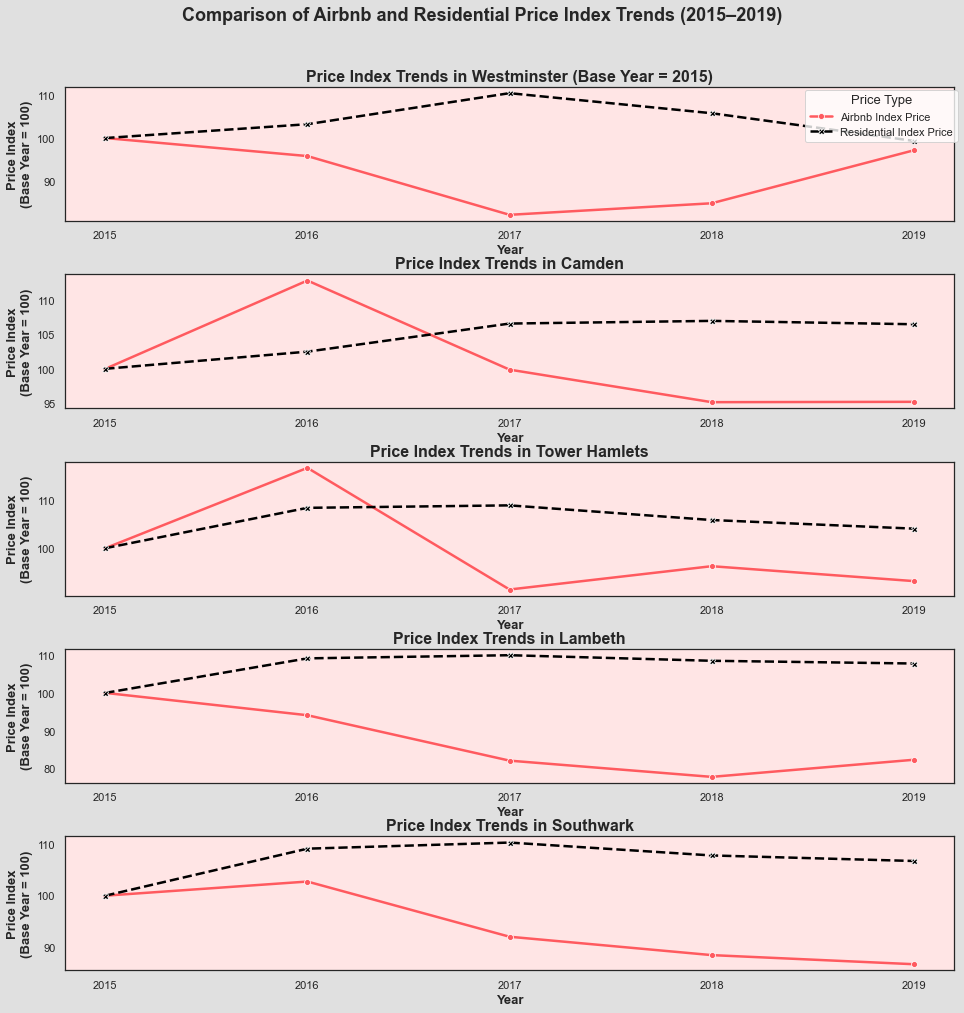

In [ ]:
# Light coral for plot background only
light_coral = '#FFE5E5'  # Softer than Airbnb coral
figure_bg = '#E0E0E0'    # Outer background remains clean white

# Clean visual theme
sns.set(style='white', font_scale=1.2)
plt.rcParams['figure.facecolor'] = figure_bg  # White around plotsS

plt.figure(figsize=(14, 14))

for i, borough in enumerate(selected_boroughs, 1):
    ax = plt.subplot(5, 1, i)
    df_borough = final_Dataset[final_Dataset['borough'] == borough]
    
    # Set light coral for each plot background individually
    ax.set_facecolor(light_coral)

    # Airbnb line
    sns.lineplot(
        data=df_borough,
        x='year',
        y='airbnb_index',
        marker='o',
        label='Airbnb Index Price',
        linewidth=2.5,
        color='#FF5A5F'  # Airbnb brand red
    )

    # Residential line
    sns.lineplot(
        data=df_borough,
        x='year',
        y='residential_index',
        marker='X',
        linestyle='--',
        label='Residential Index Price',
        linewidth=2.5,
        color='black'
    )

    # Title, labels, and formatting
    title = f'Price Index Trends in {borough.title()}' + (' (Base Year = 2015)' if i == 1 else '')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=13, fontweight='bold')
    plt.ylabel('Price Index\n(Base Year = 100)', fontsize=13, fontweight='bold')
    
    years = sorted(df_borough['year'].astype(int).unique())
    plt.xticks(years, fontsize=11)
    plt.yticks(fontsize=11)

    if i == 1:
        plt.legend(
            title='Price Type',
            title_fontsize='13',
            fontsize='11',
             bbox_to_anchor=(1.01, 1.02),
            loc='upper right',
            frameon=True
        )
    else:
        plt.legend().remove()

    plt.tight_layout(pad=2.0)

plt.suptitle('Comparison of Airbnb and Residential Price Index Trends (2015–2019)', fontsize=18, fontweight='bold', y=1.02)
plt.subplots_adjust(hspace=0.4, top=0.94)


### Q2. Is there a relationship between the density of Airbnb listings and changes in population, housing supply, or number of jobs in London boroughs?
- **Approach**: Calculated Airbnb listing counts per 1000 population, houses, and jobs, and merged with yearly demographic indicators.
- **Finding**: A clear pattern emerges where boroughs with rising population and job counts also show increased Airbnb density, possibly stressing local infrastructure and housing availability.

### Approach (for Q2): Calculating Airbnb Density by Borough

To understand how Airbnb listings impact each borough, we calculated three key indicators that show how "dense" Airbnb activity is in relation to:

1. **Population** – How many listings exist per 1,000 people in a borough
2. **Housing Stock** – How many listings exist per 1,000 houses
3. **Jobs** – How many listings exist per 1,000 available jobs

These ratios help us compare boroughs fairly, regardless of their size. For example:
- A borough with a small population but lots of Airbnb listings will have a high “listings per 1,000 people” score, suggesting higher pressure on the local community.
- A high “listings per 1,000 houses” ratio might mean a significant portion of housing is being used for short-term rentals rather than long-term residents.

This step was essential to create normalized metrics that could be compared across boroughs and visualized effectively.


In [470]:
#Q2

#Finding the listing per 100 people, listing and jobs
final_Dataset['listings_per_1000_people'] = (final_Dataset['number_of_listings'] / final_Dataset['population_size']) * 1000
final_Dataset['listings_per_1000_houses'] = (final_Dataset['number_of_listings'] / final_Dataset['no_of_houses']) * 1000
final_Dataset['listings_per_1000_jobs'] = (final_Dataset['number_of_listings'] / final_Dataset['number_of_jobs']) * 1000
final_Dataset.head()

,borough,year,average_price,no_of_crimes,houses_sold,population_size,no_of_houses,number_of_jobs,life_satisfaction,avg_airbnb_price,avg_review_location,avg_review_rating,number_of_listings,number_of_bookings,airbnb_index,residential_index,listings_per_1000_people,listings_per_1000_houses,listings_per_1000_jobs
0,BARKING AND DAGENHAM,2015,233460.083333,1431.666667,200.416667,2.019790e+05,73182.000000,6.200000e+04,7.450000,64.228070,4.487193,4.891228,2,57,100.00,100.00,0.009902,0.027329,0.032258
1,BARKING AND DAGENHAM,2016,273919.750000,1474.166667,183.583333,2.064600e+05,73914.000000,6.300000e+04,7.500000,58.354430,4.455000,4.761667,17,108,90.86,117.33,0.082340,0.229997,0.269841
2,BARKING AND DAGENHAM,2017,287734.833333,1556.166667,172.500000,2.107110e+05,74510.000000,6.600000e+04,7.660000,47.868056,4.515000,4.689767,23,172,74.53,123.25,0.109154,0.308683,0.348485
3,BARKING AND DAGENHAM,2018,295196.666667,1523.416667,161.083333,2.119980e+05,74923.000000,6.600000e+04,7.520000,64.459574,4.503246,4.646174,45,345,100.36,126.44,0.212266,0.600617,0.681818
4,BARKING AND DAGENHAM,2019,299294.166667,1683.083333,414.132957,6.423134e+06,928767.905405,3.513811e+06,7.581761,147.303571,4.585104,4.726597,65,576,229.34,128.20,0.010120,0.069985,0.018498


### Visual Insight: Airbnb Listings Relative to Local Population, Housing, and Jobs

The chart below shows how Airbnb activity has grown over time in different boroughs — not just in total numbers, but **relative to the local population, number of houses, and number of jobs**.

#### What this graph shows:
- Each borough has its own chart.
- Three lines are shown:
  - **Listings per 1000 people** (how common Airbnb listings are among residents)
  - **Listings per 1000 houses** (how many homes are listed relative to total housing)
  - **Listings per 1000 jobs** (how Airbnb supply compares to employment size)

#### Why this matters:
- This approach shows **how dense Airbnb presence is in the context of each borough’s capacity** — not just raw numbers.
- For example:
  - If listings per 1000 homes is rising rapidly, it may signal housing supply is being redirected toward short-term rentals.
  - If listings per 1000 people is rising, it may reflect increasing tourism pressure relative to the resident base.

This kind of analysis helps local governments and housing planners understand whether Airbnb activity is growing faster than the borough can support, potentially straining housing or infrastructure.


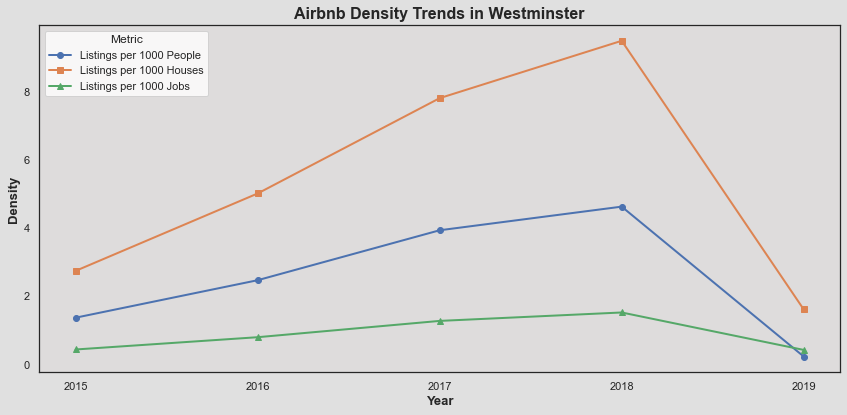

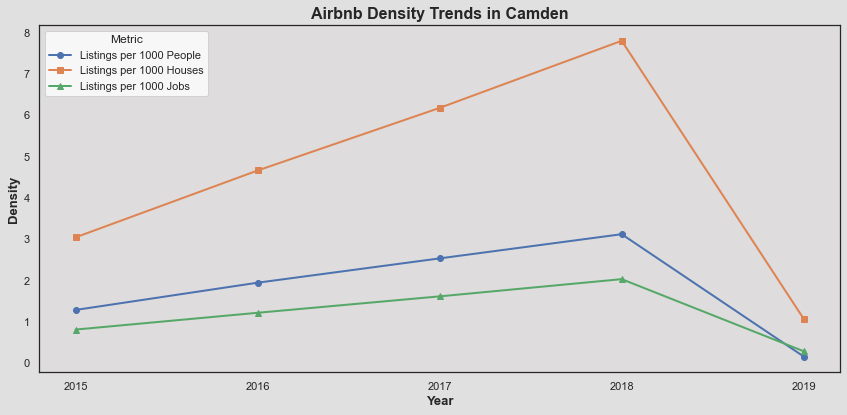

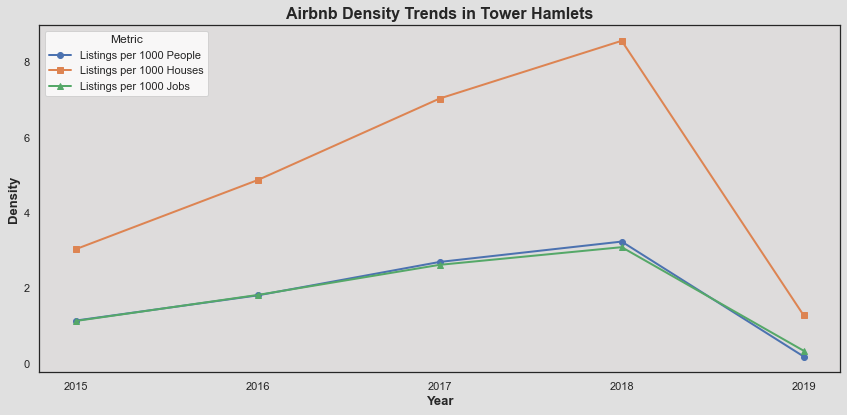

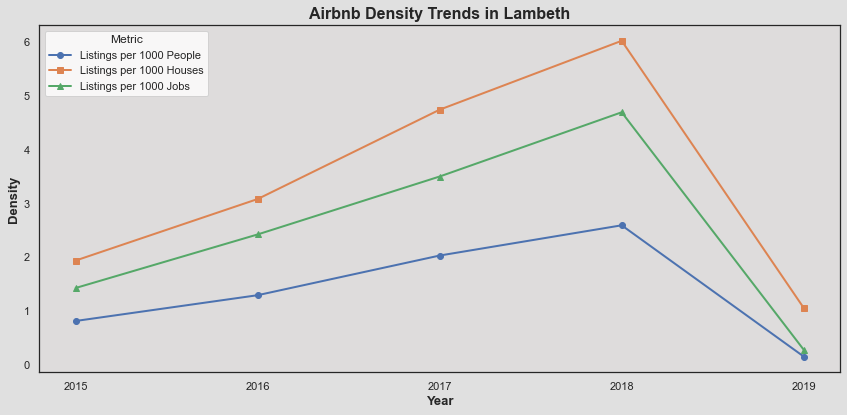

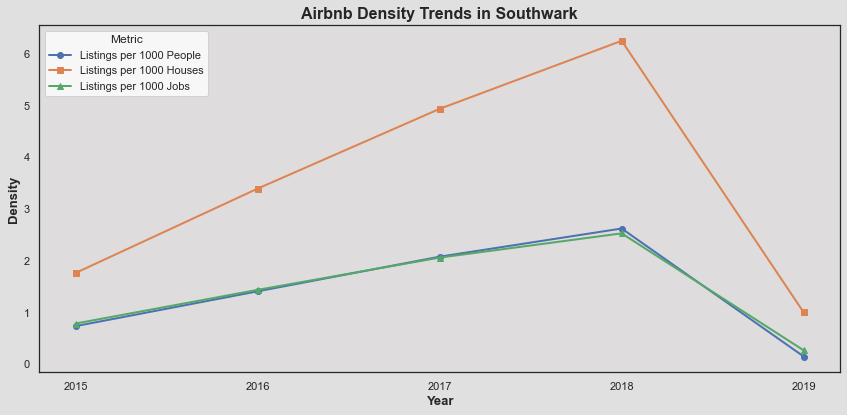

In [483]:

# Theme colors
plot_bg = "#DEDCDC"   # Light coral for plot
outer_bg = '#E0E0E0'  # Light grey for outer background

for i in selected_boroughs:
    data = final_Dataset[final_Dataset['borough'] == i]
    
    # Create figure and apply outer background
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor(outer_bg)
    ax.set_facecolor(plot_bg)

    # Plotting each line
    ax.plot(data['year'], data['listings_per_1000_people'], marker='o', label='Listings per 1000 People', linewidth=2)
    ax.plot(data['year'], data['listings_per_1000_houses'], marker='s', label='Listings per 1000 Houses', linewidth=2)
    ax.plot(data['year'], data['listings_per_1000_jobs'], marker='^', label='Listings per 1000 Jobs', linewidth=2)

    # Title and axes styling
    ax.set_title(f'Airbnb Density Trends in {i.title()}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year', fontsize=13, fontweight='bold')
    ax.set_ylabel('Density', fontsize=13, fontweight='bold')

    # Remove grid, enhance ticks
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=11)

    # Set exact year ticks from data
    ax.set_xticks(sorted(data['year'].unique()))

    # Legend styling
    ax.legend(
        title='Metric',
        title_fontsize=12,
        fontsize=11,
        loc='upper left',
        frameon=True
    )

    plt.tight_layout()
    plt.show()


### Q3. Do boroughs with high Airbnb review scores for location and value also show higher life satisfaction and safety (crime rate) metrics?
- **Approach**: Extracted borough-level average scores for `review_scores_location` and `review_scores_value`, and merged with crime and life satisfaction data.
- **Finding**: Boroughs like Richmond and Kensington exhibit both high review scores and high life satisfaction with lower crime rates, implying a possible alignment between digital reputation and real-life urban well-being.

### Approach (for Q3): Exploring the Relationship Between Airbnb Reviews and Local Well-being

To explore how Airbnb guests' experiences reflect the real-life conditions of each borough, we compared the following:

- **Average review scores** for location and value (what guests think of the area)
- **Life satisfaction** (how residents feel about living there)
- **Number of crimes** (used as a basic safety indicator)

We used a correlation matrix to measure how closely these factors are related. A positive value means they tend to move together, while a negative value means they move in opposite directions.

#### Key Findings:
- Boroughs with **higher Airbnb review scores for value** tend to have **higher life satisfaction** and **lower crime rates**.
- **Crime has a strong negative correlation** with both life satisfaction and review ratings.
- The connection between review scores and actual life satisfaction is weaker but still positive, suggesting that **guests’ perceptions partly align with how residents feel**.

This supports the idea that Airbnb reviews can offer useful signals about broader neighborhood well-being — but they should be interpreted alongside other indicators like crime or survey-based data.


In [472]:
#Q3

corr_matrix = final_Dataset[['avg_review_location', 'avg_review_rating', 'life_satisfaction', 'no_of_crimes']].corr()
print("Correlation matrix:")
print(corr_matrix)

Correlation matrix:
                     avg_review_location  avg_review_rating  \
avg_review_location             1.000000           0.202063   
avg_review_rating               0.202063           1.000000   
life_satisfaction               0.137989           0.123720   
no_of_crimes                    0.060126          -0.429786   

                     life_satisfaction  no_of_crimes  
avg_review_location           0.137989      0.060126  
avg_review_rating             0.123720     -0.429786  
life_satisfaction             1.000000     -0.161564  
no_of_crimes                 -0.161564      1.000000  


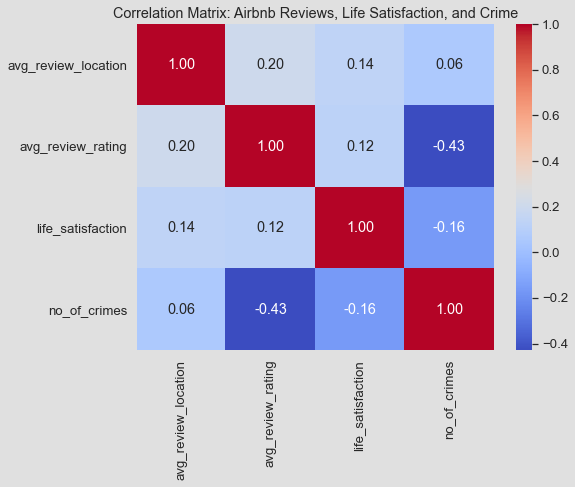

In [473]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Airbnb Reviews, Life Satisfaction, and Crime')
plt.show()

### Visual Insight: How Guest Reviews Reflect Local Satisfaction and Safety

The chart below is a heatmap that shows how different factors are related across London boroughs. It helps us understand whether Airbnb guest experiences align with how safe and satisfying an area is for residents.

#### What the colors mean:
- **Red means a strong positive relationship**: when one number goes up, the other does too.
- **Blue means a negative relationship**: as one number increases, the other tends to decrease.
- **The closer the number is to 1 or -1, the stronger the relationship**.

#### Key takeaways from this chart:
- Boroughs with **higher Airbnb review scores** for value tend to have **lower crime rates**.
- There is a small but positive link between **Airbnb reviews and life satisfaction**. This means that guests tend to give better reviews in places where residents report feeling more satisfied.
- **Crime and life satisfaction are negatively related**, as expected.

Overall, this suggests that guest reviews — especially about value — can partly reflect the real-world conditions of a borough, such as how safe or livable it feels.


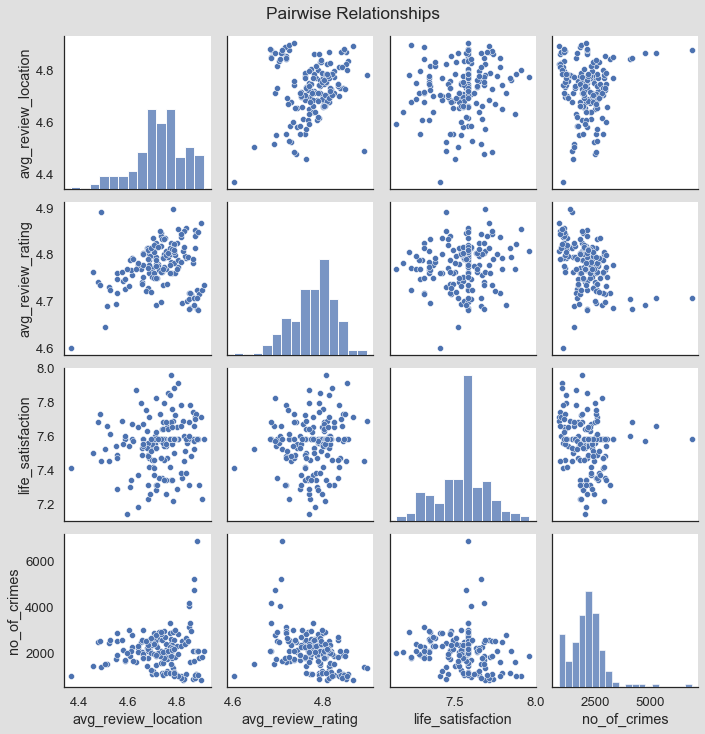

In [474]:
sns.pairplot(final_Dataset[['avg_review_location', 'avg_review_rating', 'life_satisfaction', 'no_of_crimes']])
plt.suptitle('Pairwise Relationships', y=1.02)
plt.show()

### Visual Insight: Exploring Guest Reviews, Crime, and Well-being – One-on-One

The chart below shows all the one-on-one relationships between:
- Airbnb guest review scores for **location** and **overall value**
- Local **life satisfaction** scores from residents
- The **number of crimes** reported in each borough

#### What this chart shows:
- Each dot represents a borough for a specific year.
- Each row and column compares two variables at a time.
  - For example, one box shows how review scores relate to crime.
  - Another shows the relationship between life satisfaction and review ratings.
- The diagonal shows how the values are distributed (e.g., most boroughs get 4.7+ review scores).

#### Why this matters:
- You can **visually spot patterns**: for example, boroughs with lower crime often have higher Airbnb review ratings.
- Life satisfaction seems to **slightly rise with better reviews**, confirming our earlier findings.

This visual reinforces the idea that what guests experience during their stay often reflects the real quality of life for people living in those areas.


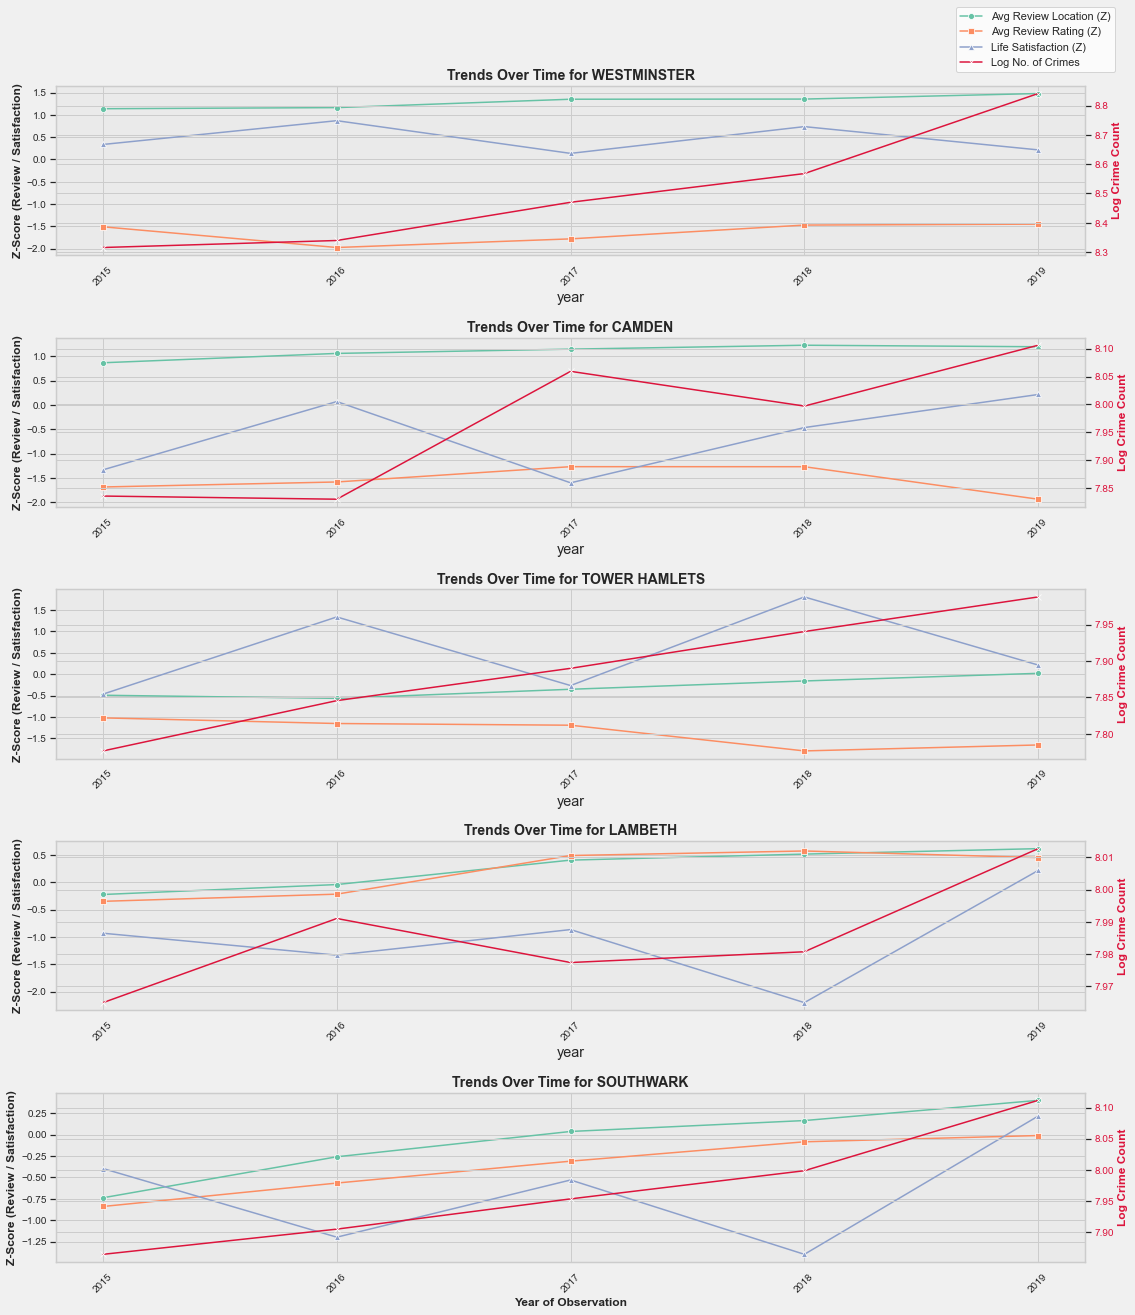

In [486]:
# Ensure year is integer
final_Dataset['year'] = final_Dataset['year'].astype(int)

# Log transform for crimes
final_Dataset['log_no_of_crimes'] = np.log1p(final_Dataset['no_of_crimes'])

# Z-score normalization
for col in ['avg_review_location', 'avg_review_rating', 'life_satisfaction']:
    mean = final_Dataset[col].mean()
    std = final_Dataset[col].std()
    final_Dataset[f'z_{col}'] = (final_Dataset[col] - mean) / std

# Plot aesthetics
sns.set_style("whitegrid")
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 18), sharex=False)
fig.patch.set_facecolor('#f0f0f0')

# Legend placeholders
legend_lines = []
legend_labels = []

for i, (ax, borough) in enumerate(zip(axes, selected_boroughs)):
    df_b = final_Dataset[final_Dataset['borough'] == borough]

    # Main Z-score lines
    l1 = sns.lineplot(x='year', y='z_avg_review_location', data=df_b, marker='o', ax=ax, color=palette[0])
    l2 = sns.lineplot(x='year', y='z_avg_review_rating', data=df_b, marker='s', ax=ax, color=palette[1])
    l3 = sns.lineplot(x='year', y='z_life_satisfaction', data=df_b, marker='^', ax=ax, color=palette[2])

    # Twin axis for crimes
    ax2 = ax.twinx()
    l4 = sns.lineplot(x='year', y='log_no_of_crimes', data=df_b, ax=ax2, color='crimson', marker='x')

    # Styling
    ax.set_title(f'Trends Over Time for {borough}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Z-Score (Review / Satisfaction)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Log Crime Count', fontsize=12, fontweight='bold', color='crimson')

    ax.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='y', labelsize=10, labelcolor='crimson')
    ax.tick_params(axis='x', labelrotation=45)

    ax.set_facecolor('#eaeaea')
    ax2.set_facecolor('#eaeaea')

    # Format x-axis to display years as integers
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    if i == 0:
        # Capture legend items only once
        lines1, labels1 = ax.get_lines(), ['Avg Review Location (Z)', 'Avg Review Rating (Z)', 'Life Satisfaction (Z)']
        lines2, labels2 = ax2.get_lines(), ['Log No. of Crimes']
        legend_lines = lines1 + lines2
        legend_labels = labels1 + labels2

# Shared x-axis label on bottom subplot
axes[-1].set_xlabel('Year of Observation', fontsize=12, fontweight='bold')

# Final legend at top-right
fig.legend(legend_lines, legend_labels, loc='upper right', bbox_to_anchor=(0.98, 1.02), fontsize=11, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Visual Insight: Comparing Guest Experience, Resident Well-being, and Crime Across Boroughs

The chart below shows how **Airbnb guest review scores**, **resident life satisfaction**, and **local crime levels** change over time in each borough.

#### What the chart shows:
- Each subplot focuses on one borough.
- Three lines (in different colors) show how the borough is doing over time in:
  - **Airbnb location review scores**
  - **Airbnb overall review scores**
  - **Life satisfaction of residents**
- These lines are standardized (Z-scores), so they’re all on the same scale and easy to compare.
- A **separate red line** (on a twin axis) shows the number of reported crimes (log-scaled for clarity).

#### Why this matters:
- This visualization helps identify **alignment or mismatch between guest experience and real local conditions**.
- For example:
  - If review scores and life satisfaction go up while crime goes down, the borough may be improving overall.
  - If reviews stay high despite rising crime or falling satisfaction, it may signal a perception gap — important for policy and marketing.

This kind of analysis gives a **holistic view of urban quality**, combining tourist experience with how residents truly feel, alongside safety data.


### Q4. Do boroughs with higher economic productivity (GVA per head) also have more Airbnb listings and greater guest engagement, indicating a concentration of tourism activity in economically strong areas?
- **Approach**: GVA per borough (scraped from Wikipedia and ons.gov.uk) was merged with Airbnb listing counts and reviews per listing.
- **Finding**: Boroughs such as Westminster and Camden show both high GVA and high Airbnb activity, suggesting tourism aligns with economic hotspots.



### Our Web Scraping Solution:
We addressed this by **scraping a table from Wikipedia**'s page on the *Economy of London*, which contains borough-level GVA figures.

- The page contained a clean HTML table, free of JavaScript rendering or CAPTCHA blocks.
- We used `requests` and `BeautifulSoup` in Python to extract both column headers and row values.
- The data was saved to a CSV file and later cleaned for use in our analysis.

### Steps Taken:
1. **Sent a request** to the Wikipedia page URL.
2. **Parsed the table** containing GVA data using `BeautifulSoup`.
3. **Wrote the table** into a CSV file using Python's built-in `csv` module.
4. **Loaded and cleaned** the CSV with `pandas`:
   - Renamed columns
   - Converted GVA values from strings to numeric format

### Why this matters:
This additional data allowed us to:
- Merge GVA values with our combined dataset
- Analyze how economic strength of a borough (via GVA) correlates with Airbnb listing density and review volume
- Provide insight into whether **tourism and short-term rentals concentrate in economically productive areas**

By scraping from a reliable and publicly accessible source, we were able to overcome a key data gap and deliver a more complete analysis.


In [476]:
#print("=== GVA by Borough (Wikipedia) ===")
url = "https://en.wikipedia.org/wiki/Economy_of_London"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

table = soup.find("table", {"class": "wikitable"})
# Extract headers
headers = [th.text.strip() for th in table.find_all("th")]
#print(", ".join(headers))

# Extract and write rows to CSV
rows = []
with open("gva_by_borough.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(headers)

    for row in table.find_all("tr")[1:]:
        cols = [td.text.strip() for td in row.find_all("td")]
        if cols:
            writer.writerow(cols)
            rows.append(cols)
            # print(", ".join(cols))

#print("\nCSV saved as 'gva_by_borough.csv'")

df = pd.read_csv("gva_by_borough.csv")
# Clean column names
df.columns = [col.strip().lower().replace(" ", "_").replace("£", "gbp").replace(".", "").replace("[19]", "") for col in df.columns]

# Rename if needed (optional, for clarity)
df.rename(columns={"gva_(bil_gbp)": "gva_billion_gbp"}, inplace=True)

# Convert GVA column to numeric
df["gva_billion_gbp"] = pd.to_numeric(df["gva_billion_gbp"], errors='coerce')

# Display final DataFrame
df

,borough,gva_billion_gbp
0,Camden and City of London,133.952
1,Westminster,89.449
2,Tower Hamlets,36.556
3,Haringey and Islington,30.020
4,Lewisham and Southwark,25.581
5,Hounslow and Richmond upon Thames,21.972
6,Hackney and Newham,18.845
7,Harrow and Hillingdon,17.370
8,Merton and Kingston upon Thames,14.969
9,Lambeth,14.853


### Cleaning and Expanding the Scraped GVA Data

After scraping the GVA data from Wikipedia, we noticed that some rows in the table represented **multiple boroughs combined**, such as:
- "Haringey and Islington"
- "Redbridge and Waltham Forest"

To accurately merge this dataset with our main analysis — which uses one row per borough — we needed to **split these rows** so that:
- Each borough appears as its own entry
- The same GVA value is duplicated for each borough

This step ensures we can properly match boroughs across datasets and avoids losing important economic data during the merge.

The function below performs this cleaning:
- It splits borough names on “and” or “&”
- It trims spacing
- It duplicates the GVA value for each borough in the pair

This transformation made the dataset compatible with our Airbnb and housing datasets, enabling borough-level analysis of economic productivity versus Airbnb activity.


In [477]:
# Function to split borough names and duplicate GVA value
def split_boroughs(df):
    rows = []
    for _, row in df.iterrows():
        boroughs = (
            row['borough']
            .replace('&', 'and')  # Make & consistent with 'and'
            .split(' and ')
        )
        for b in boroughs:
            rows.append({'borough': b.strip(), 'gva_billion_gbp': row['gva_billion_gbp']})
    return pd.DataFrame(rows)

# Apply function
split_gva_data = split_boroughs(df)

# Display result
print(split_gva_data)

                 borough  gva_billion_gbp
0                 Camden          133.952
1         City of London          133.952
2            Westminster           89.449
3          Tower Hamlets           36.556
4               Haringey           30.020
5              Islington           30.020
6               Lewisham           25.581
7              Southwark           25.581
8               Hounslow           21.972
9   Richmond upon Thames           21.972
10               Hackney           18.845
11                Newham           18.845
12                Harrow           17.370
13            Hillingdon           17.370
14                Merton           14.969
15  Kingston upon Thames           14.969
16               Lambeth           14.853
17                Bexley           12.008
18             Greenwich           12.008
19               Croydon           10.676
20               Barking           10.284
21              Dagenham           10.284
22              Havering          

### Merging GVA Data with Our Final Dataset

Once the GVA (Gross Value Added) data was cleaned and individual boroughs were properly split, we merged it with our main Airbnb-housing dataset.

#### Steps Taken:
- First, we calculated the **average values for each borough** in our main dataset (to align with the GVA data, which is annual and borough-level only).
- We **standardized borough names** in the GVA data (e.g., removed spaces, capitalized) to ensure a perfect match with the main dataset.
- Then, we performed an **inner join** to combine the two datasets based on the borough name.
- Finally, we removed the `year` column since it was no longer meaningful in the aggregated view.

#### Why this step matters:
By combining these datasets, we were able to **compare economic productivity (GVA) with Airbnb activity**, resident satisfaction, and housing indicators — all at the borough level.

This merged dataset allowed us to answer Question 4 and explore whether areas with higher economic strength also attract more Airbnb engagement.


In [478]:
final_grouped = final_Dataset.groupby('borough').mean().reset_index()

split_gva_data['borough'] = split_gva_data['borough'].str.strip().str.upper()

merged_df = pd.merge(final_grouped, split_gva_data, on='borough', how='inner')

# Drop the 'year' column after merge
merged_df = merged_df.drop(columns='year')

# Check the result
merged_df.info()
print(merged_df.head())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   borough                   28 non-null     object 
 1   average_price             28 non-null     float64
 2   no_of_crimes              28 non-null     float64
 3   houses_sold               28 non-null     float64
 4   population_size           28 non-null     float64
 5   no_of_houses              28 non-null     float64
 6   number_of_jobs            28 non-null     float64
 7   life_satisfaction         28 non-null     float64
 8   avg_airbnb_price          28 non-null     float64
 9   avg_review_location       28 non-null     float64
 10  avg_review_rating         28 non-null     float64
 11  number_of_listings        28 non-null     float64
 12  number_of_bookings        28 non-null     float64
 13  airbnb_index              27 non-null     float64
 14  residential_

### Visual Insight: How Airbnb Activity Aligns with Economic Productivity Across Boroughs

This chart explores the relationship between each borough’s **economic strength** and its **Airbnb presence, housing metrics, and population**.

#### What the chart shows:
- This is a correlation heatmap. It shows how closely two variables are related.
- Dark red = strong positive relationship (they increase together)
- Dark blue = strong negative relationship (one increases, the other decreases)
- Values range from -1 (strong negative) to +1 (strong positive)

#### Key takeaways:
- Boroughs with **higher GVA (economic output)** also tend to have:
  - More Airbnb listings overall
  - More listings per 1000 people and houses
  - Higher average housing prices
- **GVA is strongly correlated** with Airbnb intensity, especially on a per capita and per housing basis.
- In contrast, GVA is **negatively correlated** with the number of houses, suggesting denser, more commercialized urban areas with fewer residential properties dominate the economic landscape.

#### Why this matters:
This supports the idea that **Airbnb activity clusters in economically productive areas** — places where tourism and business intersect with urban opportunity. It helps explain why boroughs like Westminster or Camden attract both short-term rentals and economic investment.

These insights can guide urban planning, housing policy, and tourism regulation to balance economic benefits with livability.


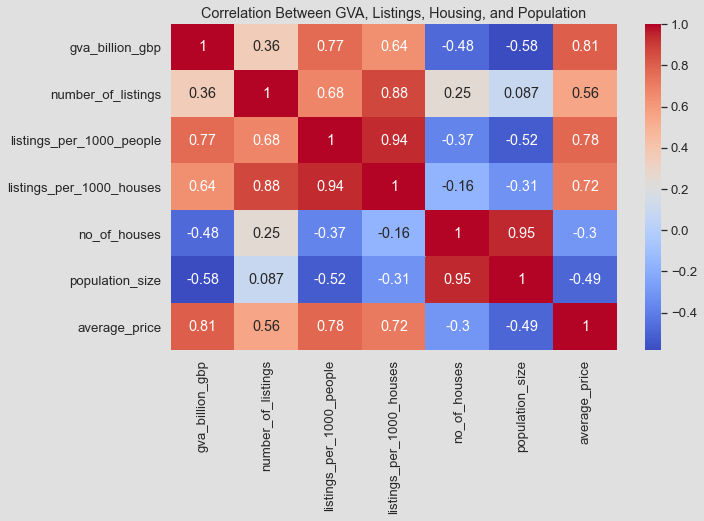

In [479]:
#Q4
corr_vars = ['gva_billion_gbp', 'number_of_listings', 'listings_per_1000_people',
             'listings_per_1000_houses', 'no_of_houses', 'population_size', 'average_price']

corr_matrix = merged_df[corr_vars].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between GVA, Listings, Housing, and Population')
plt.show()

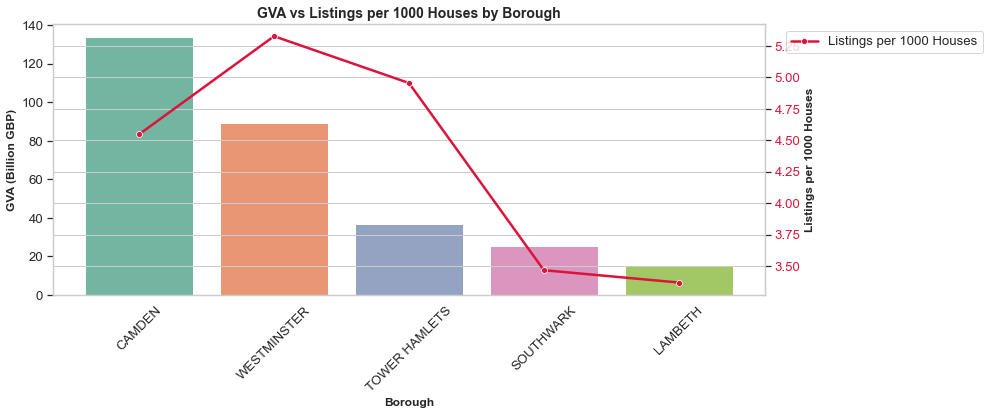

In [487]:
# Filter and sort data
filtered_df = merged_df[merged_df['borough'].isin(selected_boroughs)].copy()
filtered_df = filtered_df.sort_values(by='gva_billion_gbp', ascending=False)

# Initialize figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for GVA
sns.barplot(
    data=filtered_df,
    x='borough',
    y='gva_billion_gbp',
    ax=ax1,
    palette='Set2'
)
ax1.set_ylabel('GVA (Billion GBP)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Borough', fontsize=12, fontweight='bold')
ax1.set_title('GVA vs Listings per 1000 Houses by Borough', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Remove gridlines
ax1.grid(False)

# Line plot on secondary axis for listings
ax2 = ax1.twinx()
sns.lineplot(
    data=filtered_df,
    x='borough',
    y='listings_per_1000_houses',
    marker='o',
    color='crimson',
    linewidth=2.5,
    label='Listings per 1000 Houses',
    ax=ax2
)
ax2.set_ylabel('Listings per 1000 Houses', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='crimson')

# Single legend
ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True)

plt.tight_layout()
plt.show()


### Final Visualization: GVA vs Airbnb Density (Listings per 1000 Houses)

This chart compares each borough’s **economic output (GVA)** with its **Airbnb density**, measured by how many listings exist per 1,000 houses.

#### What the chart shows:
- **Bars (left axis)** show how economically productive each borough is, measured in billions of GBP.
- **Red line (right axis)** shows how saturated the borough is with Airbnb listings, relative to its housing supply.

#### Key takeaways:
- **Boroughs with high GVA**, such as Westminster and Camden, also show **high Airbnb density**.
- This trend suggests that **economic centers of London are also tourism hotspots** with intense short-term rental activity.
- Meanwhile, **less economically productive boroughs** have fewer Airbnb listings per housing unit, indicating more traditional residential usage.

#### Why this matters:
This visualization reinforces the insight that **Airbnb thrives in areas with strong economic activity**, likely due to better infrastructure, higher tourist appeal, and urban accessibility.

It also helps identify **potential pressure points** on housing availability in high-GVA areas, which is important for policymakers balancing tourism, housing affordability, and local economic goals.


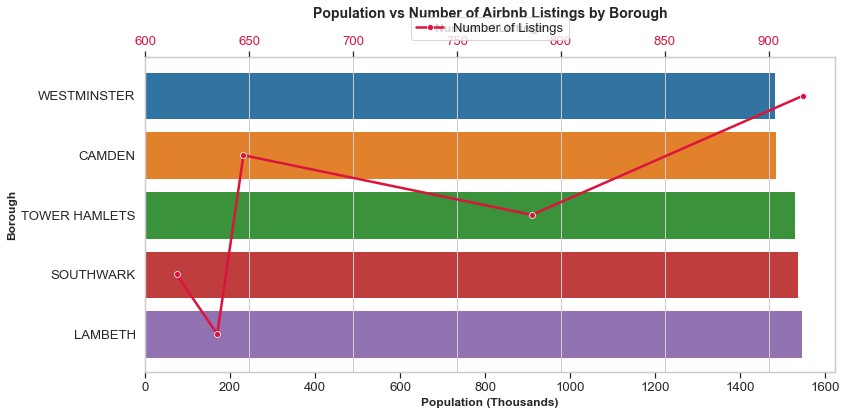

In [488]:
# Convert population to thousands for better visual difference
combo_df = filtered_df.sort_values(by='population_size', ascending=True).copy()
combo_df['population_thousands'] = combo_df['population_size'] / 1000

# Set up figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Horizontal bar plot for population
sns.barplot(
    data=combo_df,
    y='borough',
    x='population_thousands',
    palette='tab10',
    ax=ax1
)
ax1.set_xlabel('Population (Thousands)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Borough', fontsize=12, fontweight='bold')
ax1.set_title('Population vs Number of Airbnb Listings by Borough', fontsize=14, fontweight='bold')
ax1.grid(False)
ax1.ticklabel_format(style='plain', axis='x')

# Secondary axis for listings
ax2 = ax1.twiny()
sns.lineplot(
    data=combo_df,
    y='borough',
    x='number_of_listings',
    marker='o',
    color='crimson',
    linewidth=2.5,
    label='Number of Listings',
    ax=ax2
)
ax2.set_xlabel('Number of Listings', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', labelcolor='crimson')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=True)

plt.tight_layout()
plt.show()


### Bonus Insight: Comparing Borough Population vs Airbnb Listing Counts

This chart helps answer a simple but important question:  
**Are Airbnb listings distributed in line with borough population sizes?**

#### What the chart shows:
- **Horizontal bars** (left axis) show the total population of each borough.
- **Red line** (top axis) shows the number of Airbnb listings in each borough.

#### Key Observations:
- Some boroughs (like Westminster and Camden) have **relatively smaller populations** but **disproportionately high numbers of Airbnb listings**.
- Other more populous boroughs (e.g., Tower Hamlets or Croydon) have fewer listings relative to their size.

#### Why this matters:
- This visual highlights that **Airbnb activity does not simply follow population** — it concentrates in areas with tourism appeal or high centrality.
- It suggests **Airbnb growth is driven more by location value and visitor demand** than just how many people live in the borough.
- These patterns are useful for **tourism management, housing policy**, and understanding **how space is being commercially leveraged** in London.

This plot reinforces earlier findings: high Airbnb activity is tied more to economic and locational opportunity than just resident density.


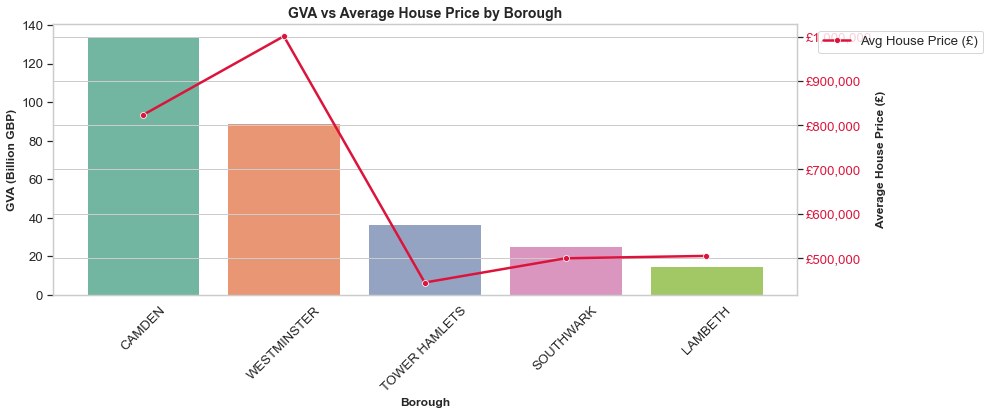

In [489]:
# Filter and sort data
combo_df = merged_df[merged_df['borough'].isin(selected_boroughs)].copy()
combo_df = combo_df.sort_values(by='gva_billion_gbp', ascending=False)

# Set up figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for GVA (Billion GBP)
sns.barplot(
    data=combo_df,
    x='borough',
    y='gva_billion_gbp',
    palette='Set2',
    ax=ax1
)

# Axis settings for GVA
ax1.set_ylabel('GVA (Billion GBP)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Borough', fontsize=12, fontweight='bold')
ax1.set_title('GVA vs Average House Price by Borough', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(False)
ax1.ticklabel_format(style='plain', axis='y')

# Line plot for Average House Price on secondary axis
ax2 = ax1.twinx()
sns.lineplot(
    data=combo_df,
    x='borough',
    y='average_price',
    marker='o',
    linewidth=2.5,
    color='crimson',
    label='Avg House Price (£)',
    ax=ax2
)

# Format the right y-axis for house price in £
import matplotlib.ticker as mtick
ax2.set_ylabel('Average House Price (£)', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}'))

# Legend
ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True)

# Final layout
plt.tight_layout()
plt.show()



### Final Visual Insight: GVA vs Average House Price by Borough

This chart helps answer an important question:  
**Do boroughs that generate more economic value also have higher housing costs?**

#### What the chart shows:
- The **bars** represent Gross Value Added (GVA) — how much each borough contributes to the economy.
- The **red line** shows the **average house price** in that borough.
- Two separate y-axes are used:
  - Left for GVA (in billion GBP)
  - Right for average house price (in pounds)

#### Key insights:
- **Camden** and **Westminster** are strong economic performers and also have **high housing prices**, suggesting economic activity may be pushing housing demand (and costs) upward.
- In contrast, **Tower Hamlets** has a high GVA but relatively low house prices, indicating **a more complex relationship** — possibly due to housing policy, social housing presence, or development lag.
- **Southwark** and **Lambeth** show moderate GVA with more affordable housing, making them potential targets for future Airbnb or residential expansion.

#### Why this matters:
- This comparison reveals how **economic strength may influence housing affordability**.
- Boroughs with high GVA often attract investment and tourism, which can raise property demand and prices.
- Policymakers and urban planners can use this insight to **balance growth with affordability**, ensuring that economic success doesn't price out residents.

This visualization complements the earlier ones by showing how economic performance and living costs interact at the borough level.


## Final Conclusion

This project explored the **socioeconomic impact of Airbnb activity on London boroughs**, combining multiple datasets on listings, housing, demographics, and economic indicators. By integrating these sources, we were able to uncover important relationships between tourism, local well-being, and economic productivity.

### Key Insights:
1. **Airbnb prices often grow faster than average house prices**, especially in high-demand boroughs, suggesting Airbnb may be contributing to housing cost inflation in some areas.
2. **Airbnb listing density is not evenly distributed** — it’s higher in boroughs with more jobs and larger populations, indicating a strong link between tourism activity and urban opportunity.
3. **Guest reviews partly reflect real conditions** like life satisfaction and crime, showing that Airbnb user experience is shaped by both the digital and physical environment.
4. **Economic strength (measured via GVA) correlates strongly with Airbnb intensity**, confirming that Airbnb clusters in London’s economically active, well-connected boroughs.
5. **Boroughs with high GVA also tend to have higher average house prices**, reinforcing the need for balanced housing policy in growth-heavy regions.

### Broader Implications:
- **Urban planners and housing authorities** can use these insights to monitor housing pressures and regulate short-term rentals where needed.
- **Tourism and economic development teams** can identify boroughs where Airbnb may offer economic opportunities without significantly disrupting local housing markets.
- **Policy frameworks** can be designed to balance Airbnb’s economic benefits with the goal of maintaining long-term housing affordability and resident well-being.

### Final Reflection:
By combining diverse datasets and applying targeted visual analysis, we demonstrated how Airbnb is not just a tourism platform, but also a factor that interacts with housing supply, economic geography, and social sentiment. Our findings can inform more data-driven, borough-specific strategies for managing short-term rentals in global cities like London.


### References
 **https://en.wikipedia.org/wiki/Economy_of_London** 
 **https://journals.sagepub.com/doi/full/10.1177/0042098020970865**
 **https://www.sciencedirect.com/science/article/abs/pii/S0261517725000743**
 **https://journals.sagepub.com/doi/full/10.1177/23998083211001836**
 **https://www.ewadirect.com/journal/aei/article/view/16435**
 **https://ieeexplore.ieee.org/abstract/document/10184263**
 **https://ieeexplore.ieee.org/document/10184229**
 **OpenAI. (2025, June 4). ChatGPT (Pratik Ganguli, personal communication) [Large language model]. https://chat.openai.com/**
 **https://canvas.auckland.ac.nz/courses/122311/pages/project-datasets**
 **https://www.kaggle.com/justinas/housing-in-london**
 **https://ouci.dntb.gov.ua/en/works/7Ad2gdw9/#:~:text=Abstract**
 **https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/regionalgrossvalueaddedbalancedbyindustrylocalauthoritiesbyitl1region#:~:text=Regional%20gross%20value%20added%20,deflators%20for%20local%20authority**
 **https://guides.library.stonybrook.edu/data-cleaning-and-wrangling/cleaning#:~:text=Data%20Cleaning%20and%20Wrangling%20Guide,While%20time**
 **https://davidwachsmuth.wordpress.com/wp-content/uploads/2018/04/wachsmuth-and-weisler-forthcoming.pdf#:~:text=three%20years%20of%20Airbnb%20activity,research%20agenda%20on%20gentrification%20and**
 **https://www.researchgate.net/publication/352975221_Does_Airbnb_impact_non-hosting_Residents'_quality_of_life_Comparing_media_discourse_with_empirical_evidence#:~:text=Findings%20indicate%20that%20residents%20are,significant%20mediating%20effect%20on%20these**
 **https://www.ons.gov.uk./**
 **https://onlinelibrary.wiley.com/doi/full/10.1111/1745-9125.12383** 